## Importing Libraries

In [1]:
#Basic Functionalities:
import os
import pandas as pd
import numpy as np

#PyTorch
import torchvision
import torch
import timm
from torch import optim
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms.functional import crop
from torch.utils.data import Dataset
from torch import nn
from torchinfo import summary

#Metrics
import seaborn as sb
import matplotlib.pyplot as plt

# Misc.
import PIL
import cv2
import time
import warnings
from skimage.color import rgb2lab, lab2rgb
from tqdm.notebook import tqdm_notebook

warnings.filterwarnings("ignore")

#Selecting device
device="cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device}")

Using cuda


### Constants

In [2]:
BATCH_SIZE=8
SEQ_LEN=5

### Dataset Creation

In [3]:
class dataset(Dataset):
    
    def __init__(self, color_dir: str, sequence_len: int = 13):
        self.color_images = sorted([os.path.join(color_dir, i) for i in (os.listdir(color_dir))], key=lambda x: int(x.split("/")[-1].split(".")[0]))
        self.sequence = self.sequencify(self.color_images, sequence_len)

        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize((256, 256), PIL.Image.BICUBIC),
            torchvision.transforms.RandomHorizontalFlip(),
        ])
        
    def __len__(self):
        return len(self.sequence)

    def sequencify(self, color_images: list, sequence_len: int):
        sequence = [color_images[i:i + sequence_len] for i in range(0, len(color_images), sequence_len)]
        return sequence
                
    def __getitem__(self, index):
        sequence_paths = self.sequence[index]
        to_return = torch.empty((len(sequence_paths), 3, 256, 256))

        for i, path in enumerate(sequence_paths):
            img = PIL.Image.open(path).convert("RGB")
            img = self.transforms(img)
            img_lab = rgb2lab(np.array(img)).astype("float32")
            img_lab = torchvision.transforms.ToTensor()(img_lab)
            to_return[i] = img_lab
            
        return to_return


In [4]:
train_ds=dataset("../Dataset/train_bc/",SEQ_LEN)
test_ds=dataset("../Dataset/test_op/",SEQ_LEN)

#### Checking dataset class

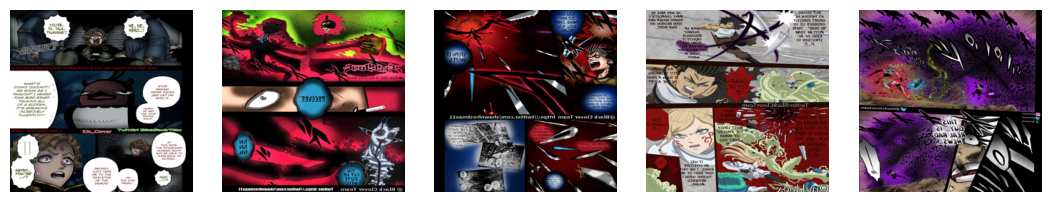

In [5]:
rand = torch.randint(50, (1,))
rand=0
plt.figure(figsize=(15, 12))  

for i in range(1, len(test_ds[rand]) + 1):
    plt.subplot(6, 7, i)
    plt.axis(False)
    plt.imshow(lab2rgb(train_ds[rand][i - 1].permute((1, 2, 0))))

plt.tight_layout()  
plt.show()

#### Data Loaders

In [6]:
train_loader=torch.utils.data.DataLoader(train_ds,BATCH_SIZE)
test_loader=torch.utils.data.DataLoader(test_ds,BATCH_SIZE)

print(f"Train Loader Batch Shape: {next(iter(train_loader)).shape}")
print(f"Test Loader Batch Shape: {next(iter(test_loader)).shape}")

Train Loader Batch Shape: torch.Size([8, 5, 3, 256, 256])
Test Loader Batch Shape: torch.Size([8, 5, 3, 256, 256])


### Model Definition

#### U-Net

In [7]:
def build_res_unet(n_input=1, n_output=2, size=256):
    body = create_body(resnet18(), n_in=n_input, pretrained=True, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

#### N-dim LSTM

In [8]:
class NDIM_LSTM(nn.Module):
    
    def __init__(self,size):
        super().__init__()

        self.percent_ltr_input=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.percent_ltr_stm_wt=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.b1=nn.Parameter(torch.tensor(0.),requires_grad=False)

        self.percent_potential_ltm_stm_wt=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.percent_potential_ltm_input=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.b2=nn.Parameter(torch.tensor(0.),requires_grad=False)
        
        self.potential_ltm_stm_wt=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.potential_ltm_input=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.b3=nn.Parameter(torch.tensor(0.),requires_grad=False)
        
        self.output_stm_contri_stm_wt=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.output_stm_contri_input=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.b4=nn.Parameter(torch.tensor(0.),requires_grad=False)

    def lstm_unit(self,input_value,long_memory,short_memory):
        
        long_remember_percent=torch.sigmoid((input_value*self.percent_ltr_input)+
                                            (self.percent_ltr_stm_wt*short_memory)+
                                            self.b1)
        
        potential_remember_percent=torch.sigmoid((input_value*self.percent_potential_ltm_input)+
                                                 (short_memory*self.percent_potential_ltm_stm_wt)+
                                                  self.b2)

        potential_memory = torch.tanh((short_memory * self.potential_ltm_stm_wt) + 
                                  (input_value * self.potential_ltm_input) + 
                                  self.b3)
        
        updated_long_memory = ((long_memory * long_remember_percent) + 
               (potential_remember_percent * potential_memory))

        output_percent = torch.sigmoid((short_memory * self.output_stm_contri_stm_wt) + 
                                       (input_value * self.output_stm_contri_input) + 
                                       self.b4)         
        
        updated_short_memory = torch.tanh(updated_long_memory) * output_percent

        return([updated_long_memory, updated_short_memory])

    def forward(self, input, long_memory=0, short_memory=0): 
        
        return self.lstm_unit(input,long_memory,short_memory)

### Exploring U-Net

In [9]:
model_test=build_res_unet
model_test().layers[3]

Sequential(
  (0): ConvLayer(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
)

In [10]:
idk=nn.ModuleList(model_test().layers)
idk=idk.to("cpu")

In [11]:
something=torch.rand(1,1,256,256)

In [12]:
for i in range(3):
    something=idk[i](something)

In [13]:
something=idk[3](something)

In [14]:
idk[3]

Sequential(
  (0): ConvLayer(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
)

In [15]:
files=next(iter(train_loader))[0]
image=files[0][0].unsqueeze(dim=0)/ 50. - 1. 
image=image.unsqueeze(dim=0)
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("../model_weights/fine_tuned_generator_weights.pt"))

<All keys matched successfully>

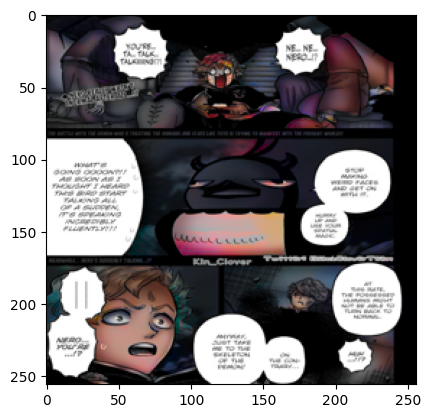

In [16]:
net_G=net_G.to("cpu")

with torch.inference_mode():
    output1=net_G(image)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
plt.imshow(lab_to_rgb(image,output1)[0])

In [17]:
idk=net_G

In [18]:
idk=idk.layers

In [19]:
idk

ModuleList(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [20]:
something=image

In [21]:
something.shape

torch.Size([1, 1, 256, 256])

In [22]:
len(idk)

14

In [32]:
resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
idk[0]

Sequential(
  (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [39]:
idk[11].convpath[0][0]

Conv2d(97, 97, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [25]:
idk[9]

ResizeToOrig()

In [26]:
something=image
for i in range(len(idk)):
    print(i,something.shape)
    something=idk[i](something)
    

0 torch.Size([1, 1, 256, 256])
1 torch.Size([1, 512, 8, 8])
2 torch.Size([1, 512, 8, 8])
3 torch.Size([1, 512, 8, 8])
4 torch.Size([1, 512, 8, 8])
5 torch.Size([1, 512, 16, 16])
6 torch.Size([1, 384, 32, 32])
7 torch.Size([1, 256, 64, 64])
8 torch.Size([1, 96, 128, 128])
9 torch.Size([1, 96, 256, 256])


AttributeError: 'Tensor' object has no attribute 'orig'

In [ ]:
summary(model_test())

### Overall model

In [ ]:
class ColorNet:
    def __init__(self, net_G, lstm):
        self.net_G=net_G
        self.lstm=lstm()